In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pickle
import gc

#import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


from lnn_model import JetParticleDataset_ltc, BinaryClassificationLTC

from transformer_scratch import Part, JetParticleDataset_part

from mlp_model import JetParticleDataset_mlp, MLP_Adjustable

In [3]:
print('Preparing data...')

N = 16         
reverse = ''#'_reversed'
file_path = f'/home/asugu/work/event_data_tt_pad{N}_4mom{reverse}.pkl'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['btag'])


Preparing data...


In [4]:
df_btag_0_train = train_df[train_df['btag'] == 0]
df_btag_1_train = train_df[train_df['btag'] == 1]

df_btag_0_test = test_df[test_df['btag'] == 0]
df_btag_1_test = test_df[test_df['btag'] == 1]

In [ ]:
"""features = [
    'track_E', 'track_pt', 'track_px', 'track_py', 'track_pz',
    'track_pid', 'track_charge', 'track_d0', 'track_dz',
    'track_d0_sig', 'track_dz_sig'
]

xmin = [0,0,-100,-100,-100,-2500,-1,-200,-200,0,0]
xmax = [500,100,100,100,100,2500,1,200,200,0.3,0.3]

cmap = matplotlib.colormaps.get_cmap('Spectral')
fig, axes = plt.subplots(nrows=2, ncols = 6, figsize = (24, 8))

for i,feature in enumerate(features):
    # Initialize an empty list to collect all values
    all_values_btag_0_train = []
    all_values_btag_1_train = []

    all_values_btag_0_test = []
    all_values_btag_1_test = []

    # Iterate over the flattened arrays and collect all values
    for index, row in df_btag_0_train.iterrows():
        all_values_btag_0_train.extend(row[feature].flatten())
    for index, row in df_btag_1_train.iterrows():
        all_values_btag_1_train.extend(row[feature].flatten())

    for index, row in df_btag_0_test.iterrows():
        all_values_btag_0_test.extend(row[feature].flatten())
    for index, row in df_btag_1_test.iterrows():
        all_values_btag_1_test.extend(row[feature].flatten())

    # Create histograms for the collected values

    ax = axes[i//6, i%6]
  #  ax.figure(figsize=(8, 6))
    ax.hist(all_values_btag_0_train, density = True, bins=50, alpha=0.2, label='l(train)', color='blue')
    ax.hist(all_values_btag_1_train, density = True, bins=50, alpha=0.2, label='b(train)', color='red')
    ax.hist(all_values_btag_0_test, density = True, bins=50, label='l(test)', color='blue', histtype='step', linestyle='--')
    ax.hist(all_values_btag_1_test, density = True, bins=50, label='b(test)', color='red', histtype='step', linestyle='--')
   # ax.set_xlim([xmin[i],xmax[i]])
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Density')
    ax.set_yscale('log')
    ax.legend()
   # ax.set_title(f'Histogram of {feature} for light and bottom quarks')
fig.tight_layout()
plt.show()
"""

"features = [\n    'track_E', 'track_pt', 'track_px', 'track_py', 'track_pz',\n    'track_pid', 'track_charge', 'track_d0', 'track_dz',\n    'track_d0_sig', 'track_dz_sig'\n]\n\nxmin = [0,0,-100,-100,-100,-2500,-1,-200,-200,0,0]\nxmax = [500,100,100,100,100,2500,1,200,200,0.3,0.3]\n\ncmap = matplotlib.colormaps.get_cmap('Spectral')\nfig, axes = plt.subplots(nrows=2, ncols = 6, figsize = (24, 8))\n\nfor i,feature in enumerate(features):\n    # Initialize an empty list to collect all values\n    all_values_btag_0_train = []\n    all_values_btag_1_train = []\n\n    all_values_btag_0_test = []\n    all_values_btag_1_test = []\n\n    # Iterate over the flattened arrays and collect all values\n    for index, row in df_btag_0_train.iterrows():\n        all_values_btag_0_train.extend(row[feature].flatten())\n    for index, row in df_btag_1_train.iterrows():\n        all_values_btag_1_train.extend(row[feature].flatten())\n\n    for index, row in df_btag_0_test.iterrows():\n        all_values_bt

In [5]:
from_checkpoint = True
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_part_90.pth'

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  

batch_size = 2048
n_epochs = 10
learning_rate = 0.001

input_size = N   # padded length
embed_size = 16
n_heads = 8
n_part_layers =8
n_cls_layers = 2

In [6]:
#___________ for part_________
model = Part(input_dim=input_size, embed_dim=embed_size, num_heads=n_heads, num_layers=n_part_layers, num_cls_layers=n_cls_layers) 
model= nn.DataParallel(model,device_ids = [0, 1])
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
model.to(device)



DataParallel(
  (module): Part(
    (embed): Embed(
      (input_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (embed1): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): GELU(approximate='none')
      )
      (embed2): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (conv1): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    )
    (blocks): ModuleList(
      (0-7): 8 x ParticleBlock(
        (pre_attn_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (post_attn_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
        (dropout): Dropout(p=0.0, inplace=Fal

In [7]:
train_dataset_btag_0 = JetParticleDataset_part(df_btag_0_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_0 = JetParticleDataset_part(df_btag_0_test, device=device, eval=True,scaler=scaler)

train_dataset_btag_1 = JetParticleDataset_part(df_btag_1_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_1 = JetParticleDataset_part(df_btag_1_test, device=device, eval=True,scaler=scaler)


train_dataloader_btag_0 = DataLoader(train_dataset_btag_0, batch_size=batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_0 = DataLoader(test_dataset_btag_0, batch_size=len(test_dataset_btag_0), shuffle=False, drop_last=True)    

train_dataloader_btag_1 = DataLoader(train_dataset_btag_1, batch_size= batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_1 = DataLoader(test_dataset_btag_1, batch_size=len(test_dataset_btag_1), shuffle=False, drop_last=True)    


/mnt/12TB/asu/work/part/transformer_scratch.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.particle_features.columns] = self.df[self.particle_features.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - self.scaler[0]) / self.scaler[1]).flatten() for arr in x])
/mnt/12TB/asu/work/part/transformer_scratch.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.four_momenta.columns] = self.df[self.four_momenta.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - sel

In [ ]:
#delete some sets

In [8]:
part_train_btag_0 = []
part_train_btag_1 = []
part_test_btag_0 = []
part_test_btag_1 = []

model.eval()
with torch.no_grad():
    for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels, flavors in train_dataloader_btag_0: 
            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs)
            part_train_btag_0.append(val_preds.cpu()) 
    for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels, flavors in train_dataloader_btag_1: 
            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs)
            part_train_btag_1.append(val_preds.cpu())
    for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels, flavors in test_dataloader_btag_0: 
            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs)
            part_test_btag_0.append(val_preds.cpu())
    for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels, flavors in test_dataloader_btag_1: 
            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs)
            part_test_btag_1.append(val_preds.cpu())



/home/asugu/.local/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [9]:
part_test_btag_0_cat = torch.cat(part_test_btag_0)
part_test_btag_1_cat = torch.cat(part_test_btag_1)
part_train_btag_0_cat = torch.cat(part_train_btag_0)
part_train_btag_1_cat = torch.cat(part_train_btag_1)

[tensor([0.1259, 0.1000, 0.3890,  ..., 0.1290, 0.1115, 0.0888]), tensor([0.8519, 0.6246, 0.1722,  ..., 0.1912, 0.1115, 0.0878]), tensor([0.2749, 0.0637, 0.7052,  ..., 0.1325, 0.1266, 0.1965]), tensor([0.2785, 0.1287, 0.3288,  ..., 0.3712, 0.1115, 0.1443]), tensor([0.1250, 0.4896, 0.3301,  ..., 0.3963, 0.2365, 0.1820]), tensor([0.0955, 0.1527, 0.0433,  ..., 0.4350, 0.2108, 0.3609]), tensor([0.0517, 0.5215, 0.2350,  ..., 0.4281, 0.1739, 0.0446]), tensor([0.0679, 0.5213, 0.0438,  ..., 0.1116, 0.1082, 0.1635]), tensor([0.1134, 0.1115, 0.1866,  ..., 0.5007, 0.3630, 0.2287]), tensor([0.1676, 0.1397, 0.1018,  ..., 0.1609, 0.1115, 0.0539]), tensor([0.1078, 0.2799, 0.1586,  ..., 0.5557, 0.0727, 0.2382]), tensor([0.1115, 0.3610, 0.2155,  ..., 0.6361, 0.3015, 0.0624]), tensor([0.2464, 0.1805, 0.2575,  ..., 0.1532, 0.2011, 0.0818]), tensor([0.3178, 0.1329, 0.3020,  ..., 0.3322, 0.0992, 0.4446]), tensor([0.0347, 0.5355, 0.2421,  ..., 0.0907, 0.1040, 0.0441]), tensor([0.3631, 0.8775, 0.2176,  ..., 0

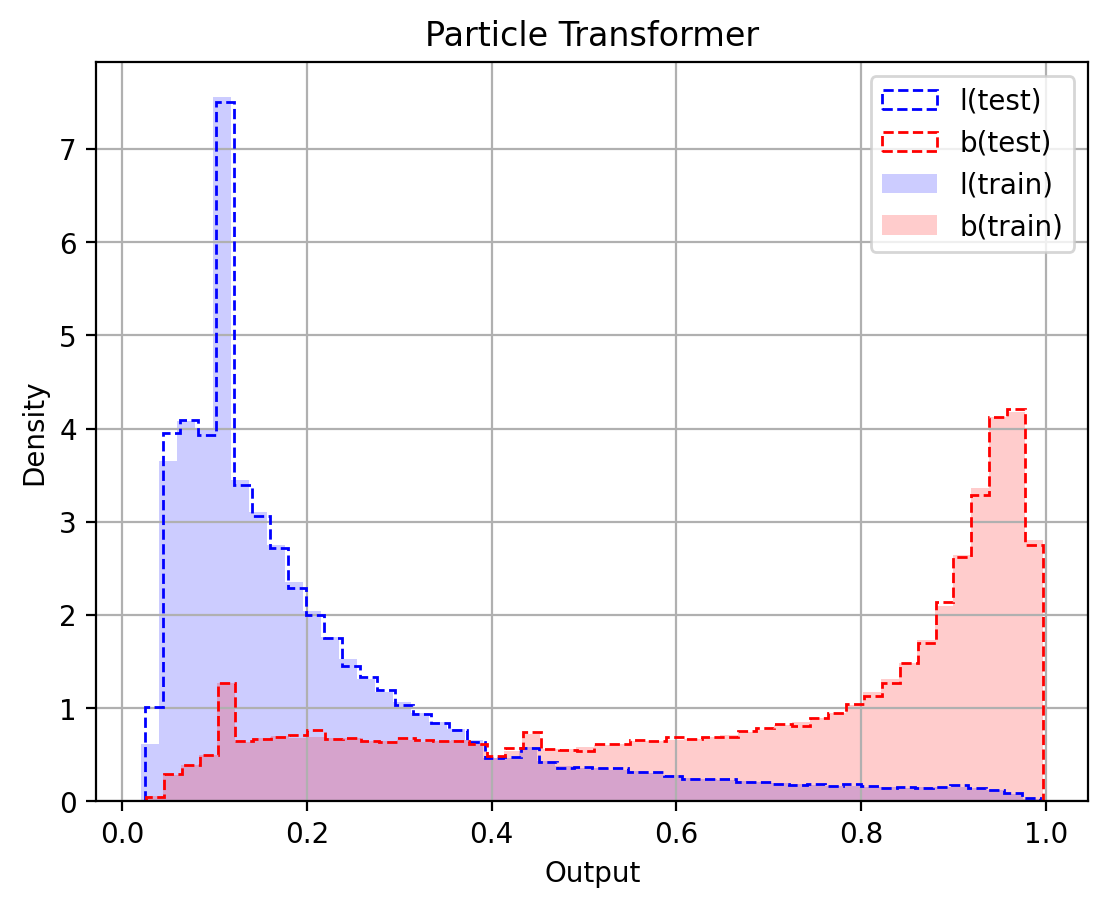

In [10]:
print(part_train_btag_0)
print( part_train_btag_0[0].cpu().numpy())

plt.hist(part_test_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, label='l(test)', color='blue', histtype='step', linestyle='--')
plt.hist(part_test_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, label='b(test)', color='red', histtype='step', linestyle='--')
plt.hist(part_train_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='l(train)', color='blue')
plt.hist(part_train_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='b(train)', color='red')

plt.xlabel('Output')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.title("Particle Transformer")

plt.show()

alloc!


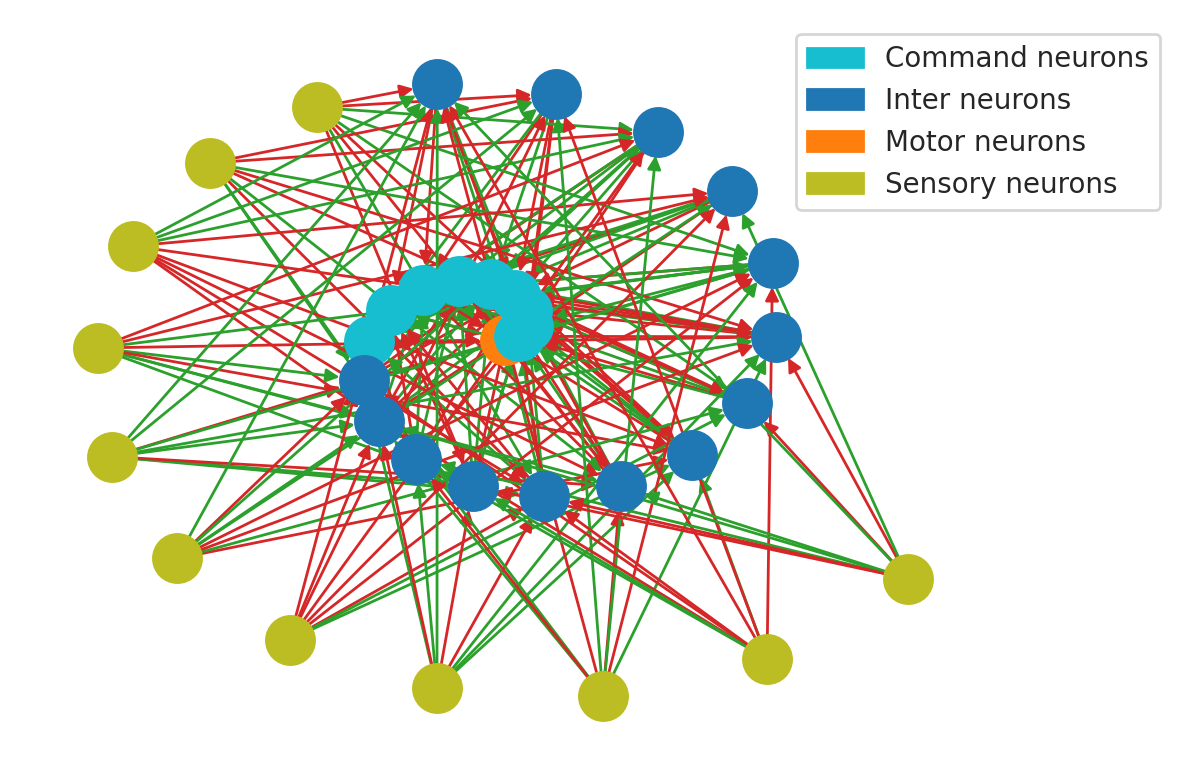

NameError: name 'device' is not defined

In [9]:
#___________ for LTC_________

checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_90.pth'
N=16
batch_size = 2048
n_epochs = 10
learning_rate = 0.01

in_features = 11
out_features = 1
hidden_units = 24
sparsity = 0.3


model = BinaryClassificationLTC(in_features,units=hidden_units, seq_len=N, sparsity=sparsity)
model.print_model(layout='spiral')


criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
model.to(device)


In [ ]:
train_dataset_btag_0 = JetParticleDataset_ltc(df_btag_0_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_0 = JetParticleDataset_ltc(df_btag_0_test, device=device, eval=True,scaler=scaler)

train_dataset_btag_1 = JetParticleDataset_ltc(df_btag_1_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_1 = JetParticleDataset_ltc(df_btag_1_test, device=device, eval=True,scaler=scaler)


train_dataloader_btag_0 = DataLoader(train_dataset_btag_0, batch_size=batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_0 = DataLoader(test_dataset_btag_0, batch_size=len(test_dataset_btag_0), shuffle=False, drop_last=True)    

train_dataloader_btag_1 = DataLoader(train_dataset_btag_1, batch_size=batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_1 = DataLoader(test_dataset_btag_1, batch_size=len(test_dataset_btag_1), shuffle=False, drop_last=True)    


/mnt/12TB/asu/work/part/lnn_model.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.particle_features.columns] = self.df[self.particle_features.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - self.scaler[0]) / self.scaler[1]).flatten() for arr in x])
/mnt/12TB/asu/work/part/lnn_model.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.particle_features.columns] = self.df[self.particle_features.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - self.scaler[0])

In [ ]:
ltc_train_btag_0 = []
ltc_train_btag_1 = []
ltc_test_btag_0 = []
ltc_test_btag_1 = []

model.eval()
with torch.no_grad():
    for val_particle_inputs, val_labels, flavors in train_dataloader_btag_0: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs, states=None)
        val_preds = val_preds.squeeze()
        ltc_train_btag_0.append(val_preds)

    for val_particle_inputs, val_labels, flavors in train_dataloader_btag_1: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs, states=None)
        val_preds = val_preds.squeeze()
        ltc_train_btag_1.append(val_preds)

    for val_particle_inputs, val_labels, flavors in test_dataloader_btag_0: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs, states=None)
        val_preds = val_preds.squeeze()
        ltc_test_btag_0.append(val_preds)

    for val_particle_inputs, val_labels, flavors in test_dataloader_btag_1: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs, states=None)
        val_preds = val_preds.squeeze()
        ltc_test_btag_1.append(val_preds)


In [ ]:
ltc_test_btag_0_cat = torch.cat(ltc_test_btag_0)
ltc_test_btag_1_cat = torch.cat(ltc_test_btag_1)
ltc_train_btag_0_cat = torch.cat(ltc_train_btag_0)
ltc_train_btag_1_cat = torch.cat(ltc_train_btag_1)

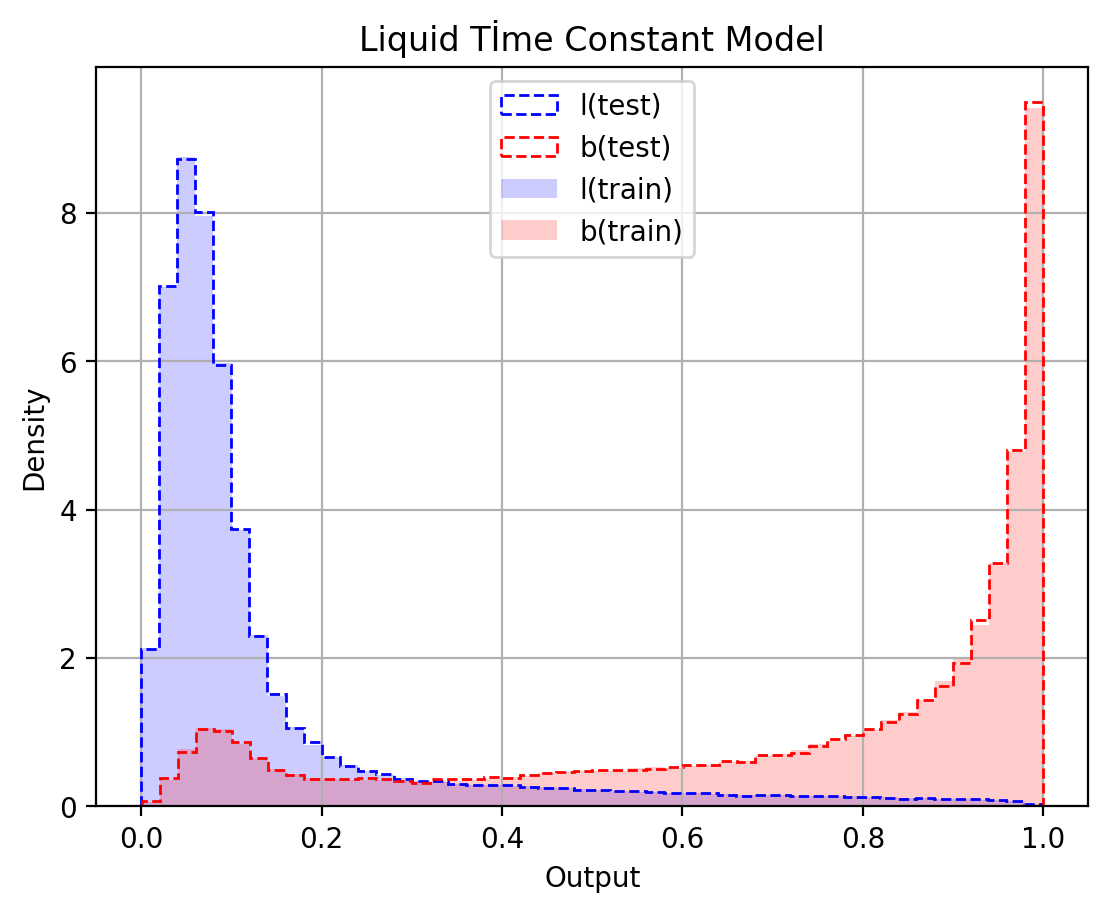

In [ ]:
plt.hist(ltc_test_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, label='l(test)', color='blue', histtype='step', linestyle='--')
plt.hist(ltc_test_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, label='b(test)', color='red', histtype='step', linestyle='--')
plt.hist(ltc_train_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='l(train)', color='blue')
plt.hist(ltc_train_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='b(train)', color='red')

plt.xlabel('Output')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.title("Liquid Tİme Constant Model")

plt.show()

In [6]:
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_MLP_131.pth'

batch_size = 2048
n_epochs = 10
learning_rate = 0.001

in_features = 11
out_features = 1

model = MLP_Adjustable(input_size=(in_features*N), output_size=1, n_hidden_layers = 4, nnodes=256)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
model.to(device)

MLP_Adjustable(
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
  )
  (layer1): Linear(in_features=176, out_features=256, bias=True)
  (layerfin): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)

In [7]:
train_dataset_btag_0 = JetParticleDataset_mlp(df_btag_0_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_0 = JetParticleDataset_mlp(df_btag_0_test, device=device, eval=True,scaler=scaler)

train_dataset_btag_1 = JetParticleDataset_mlp(df_btag_1_train, device=device, eval=False,scaler=scaler)
test_dataset_btag_1 = JetParticleDataset_mlp(df_btag_1_test, device=device, eval=True,scaler=scaler)


train_dataloader_btag_0 = DataLoader(train_dataset_btag_0, batch_size=batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_0 = DataLoader(test_dataset_btag_0, batch_size=len(test_dataset_btag_0), shuffle=False, drop_last=True)    

train_dataloader_btag_1 = DataLoader(train_dataset_btag_1, batch_size=batch_size, shuffle=False, drop_last=True)      # add workers
test_dataloader_btag_1 = DataLoader(test_dataset_btag_1, batch_size=len(test_dataset_btag_1), shuffle=False, drop_last=True)    


/mnt/12TB/asu/work/part/mlp_model.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.particle_features.columns] = self.df[self.particle_features.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - self.scaler[0]) / self.scaler[1]).flatten() for arr in x])
/mnt/12TB/asu/work/part/mlp_model.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.particle_features.columns] = self.df[self.particle_features.columns].apply(lambda x: [((np.array(arr).reshape(-1, 1) - self.scaler[0])

In [8]:
mlp_train_btag_0 = []
mlp_train_btag_1 = []
mlp_test_btag_0 = []
mlp_test_btag_1 = []


model.eval()
with torch.no_grad():
    for val_particle_inputs, val_labels, flavors in train_dataloader_btag_0: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs)
        val_preds = val_preds.squeeze()
        mlp_train_btag_0.append(val_preds)

    for val_particle_inputs, val_labels, flavors in train_dataloader_btag_1: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs)
        val_preds = val_preds.squeeze()
        mlp_train_btag_1.append(val_preds)

    for val_particle_inputs, val_labels, flavors in test_dataloader_btag_0: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs)
        val_preds = val_preds.squeeze() 
        mlp_test_btag_0.append(val_preds)

    for val_particle_inputs, val_labels, flavors in test_dataloader_btag_1: 
        val_particle_inputs = val_particle_inputs.transpose(1,2)
        val_preds = model(val_particle_inputs)
        val_preds = val_preds.squeeze()
        mlp_test_btag_1.append(val_preds)

In [9]:
mlp_test_btag_0_cat = torch.cat(mlp_test_btag_0)
mlp_test_btag_1_cat = torch.cat(mlp_test_btag_1)
mlp_train_btag_0_cat = torch.cat(mlp_train_btag_0)
mlp_train_btag_1_cat = torch.cat(mlp_train_btag_1)

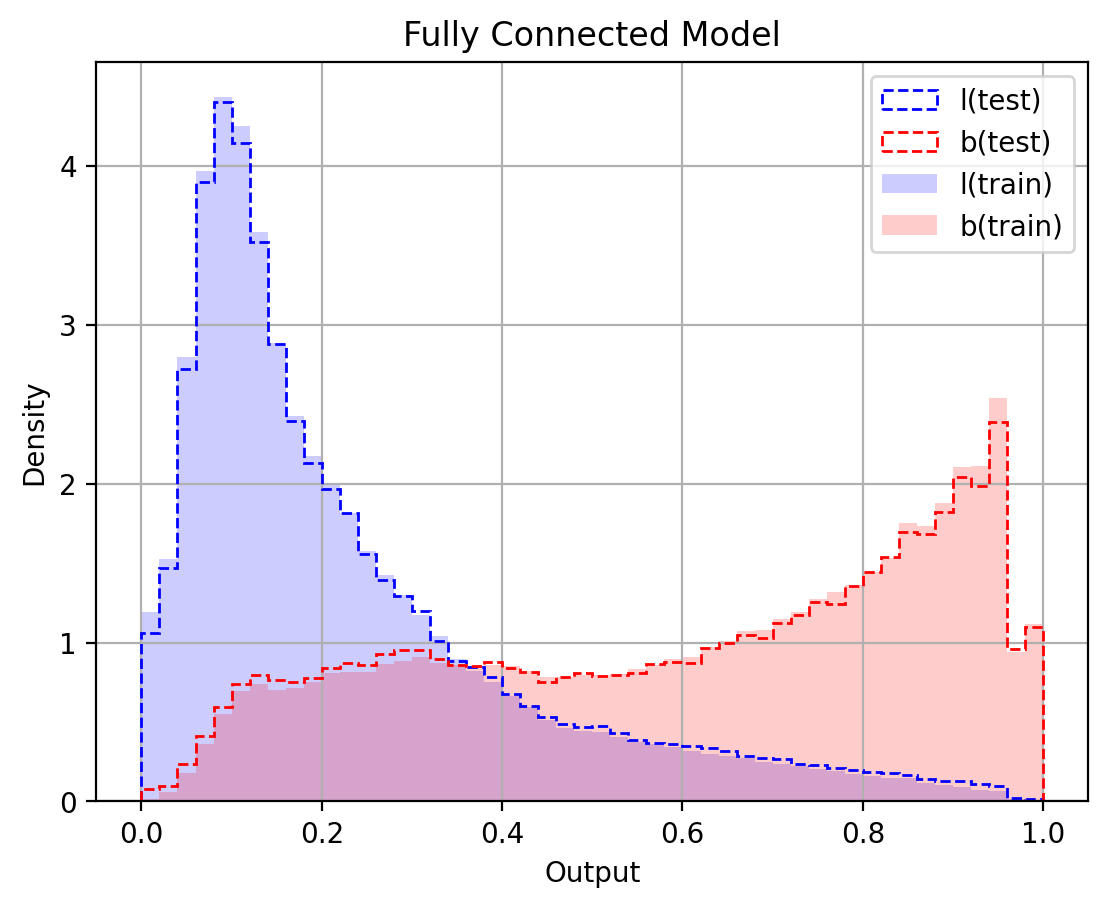

In [10]:
plt.hist(mlp_test_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, label='l(test)', color='blue', histtype='step', linestyle='--')
plt.hist(mlp_test_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, label='b(test)', color='red', histtype='step', linestyle='--')
plt.hist(mlp_train_btag_0_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='l(train)', color='blue')
plt.hist(mlp_train_btag_1_cat.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='b(train)', color='red')

plt.xlabel('Output')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.title("Fully Connected Model")

plt.show()